Reference  
https://www.kaggle.com/code/joseguzman/pytorch-simple-ann-for-mnist

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

### Download and Load MNIST Dataset

In [ ]:
### 기능: torchvision에서 제공하는 MNIST 데이터셋을 download 후 load한다.
### Params
    # train: True면 train-images-idx3-ubyte로부터 학습용 데이터셋(60,000개)을, False면 t10k-images-idx3-ubyte로부터 테스트용 데이터셋(10,000개)을 만든다.
    # transform: PIL image(input)에 적용시킬 함수. 여기서는 torchvision.transforms의 ToTensor() 함수로 지정.
        ### ToTensor() 함수: (H x W x C) [0, 255] 사잇값의 PIL 이미지 혹은 ndarray를 (C x H x W) [0.0, 1.0] 사잇값의 torch.FloatTensor로 변환하는 함수
        
train_data = datasets.MNIST(root='./dataset', download=False, train=True, transform=transforms.ToTensor())
test_data = datasets.MNIST(root='./dataset', download=False, train=False, transform=transforms.ToTensor())

In [8]:
img_sample, label_sample = train_data[0]
img_sample.shape, label_sample

(torch.Size([1, 28, 28]), 5)

(-0.5, 27.5, 27.5, -0.5)

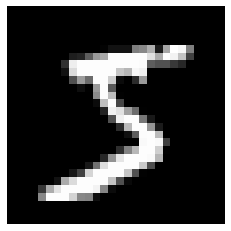

In [5]:
### imshow() 함수
    # PIL image 또는 ndarray 데이터를 이미지로 보여주는 함수
    # (M, N), (M, N, 3), 또는 (M, N, 4) shape을 input으로 받으므로 img_sample(1x28x28)은 squeeze()를 통해 shape을 (28,28)로 만들어준다.
    # cmap을 무슨 색깔로 지정해주는지에 따라 사진 색깔이 달라진다.

plt.imshow(img_sample.squeeze(), cmap='gray')
plt.axis('off')   # 주위에 axis 안보이게 하기

### DataLoader

In [10]:
# shuffle 시의 결과가 항상 동일하도록 seed를 설정
torch.manual_seed(101)

### 기능: dataset을 받아 iterable한 객체를 만들어준다.
### Params
    # batch_size: 한 step에서 학습할 데이터의 개수
    # shuffle: True이면 매 epoch마다 데이터를 새롭게 shuffle한 후 batch_size만큼 나눈다.
    
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [11]:
for sample_batch, sample_label in train_loader:
    print(sample_batch.shape, sample_label.shape)
    break

torch.Size([100, 1, 28, 28]) torch.Size([100])


### Create the Network

In [28]:
### in_features: input 벡터 1개의 길이 (28x28 = 784)
    # 신경망 가장 첫 번째 입력층의 노드 개수가 된다.
### out_features: 신경망을 거쳐 나온 최종 output 벡터의 길이
    # 신경망 가장 마지막 출력층의 노드 개수가 된다.
    # MNIST classification은 10개 label 중 하나로 분류하는 문제이므로, 출력층에 10개 값에 대한 logit이 나오게 된다. 따라서 out_features = 10
    
in_features = 784
out_features = 10

In [29]:
# MNIST 분류를 위해 은닉층이 2개인 ANN 모델 구조 정의
### nn.Sequential()
    # layer_idx, layer를 key, value로 가지고 있는 ordered_dict 구조
    # forward()를 하면 첫 번째부터 마지막 layer까지 순차적으로 실행
### nn.Linear()
    # (in_size, out_size)를 파라미터로 받아서 아래 값들을 저장
    # self.weight: torch.empty(out_size, in_size)
    # self.bias: torch.empty(out_size,)
    # self.weight과 self.bias는 init.kaiming_uniform_()으로 weight random initialization

mnist_classifier = nn.Sequential(
    nn.Linear(in_features, 120),   # 첫 번째 입력층의 노드 개수는 input 벡터 길이인 784개
    nn.ReLU(),   # 노드 개수가 120개인 첫 번째 은닉층 + ReLU() 활성화 함수 (비선형 구조로 만들기 위해 비선형 함수 사용)
    nn.Linear(120, 84),
    nn.ReLU(),   # 노드 개수가 84개인 두 번째 은닉층 + ReLU() 활성화 함수
    nn.Linear(84, out_features)   # 마지막 출력층의 노드 개수는 10개. 활성함수 nn.Softmax()는 따로 정의하지 않는다 -> 오차함수 nn.CrossEntropyLoss()에서 log softmax로 변환하기 때문
)

# Multi-label classification이므로 오차함수는 CrossEntropyLoss() 사용, optimizer는 AdamW 사용
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(mnist_classifier.parameters(), lr=1e-3)

### Training and Evaluation

In [30]:
# train, test 시에 loss와 accuracy를 저장할 클래스 정의
class Loss:
    train: list = []
    test: list = []
    
class Accuracy:
    train: list = []
    test: list = []

In [31]:
epochs = 10
for epoch in tqdm(range(epochs)):
    train_corr_cnt = 0   # 1 step 학습 시마다 pred와 label을 비교해 정답 개수를 저장할 변수
    test_corr_cnt = 0    # 매 epoch 학습이 끝나고 test set으로 평가 진행 시, 1 step 평가 시마다 pred와 label을 비교해 정답 개수를 저장할 변수
    
    # train
    for batch_idx, (img, label) in enumerate(train_loader, 1):
        y_pred = mnist_classifier(img.view(100, -1))   # 현재 한 batch의 shape은 (100, 1, 28, 28)인데, 신경망 input으로 들어가려면 1차원 벡터여야 하므로 (100, 784)로 만들어준다. y_pred의 shape은 (100, 10)
        loss = loss_func(y_pred, label)  # nn.CrossEntropyLoss()로 오차 계산
        
        _, prediction = torch.max(y_pred, dim=1)  # 10개 logit값 중에서 가장 큰 logit값을 찾고, 해당 값의 인덱스를 prediction 변수로 반환 # prediction.shape은 (100, )
        train_corr_cnt += (prediction == label).sum()  # 1 학습 step마다 예측된 label값과 정답 label값 비교 후 True 개수를 train_corr_cnt에 누적하여 저장
        
        optimizer.zero_grad()  # optimizer 초기화
        loss.backward()  # 오차역전파
        optimizer.step()  # 모델 weight 업데이트
        
        # batch_idx가 200의 배수일 때마다 지금까지의 누적 accuracy를 출력한다.
        # acc = (지금까지 맞춘 개수) / (지금까지 학습한 데이터 개수) * 100
        if batch_idx % 200 == 0:
            acc = (train_corr_cnt / (batch_idx*100)) * 100
            print(f"Epoch:{epoch:2d} Batch:{batch_idx:2d} Loss:{loss:4.4f} Accuracy:{acc:4.4f}%")
            
    Loss.train.append(loss.item())   # 1 epoch 학습이 끝나면 가장 마지막 loss를 Loss.train에 저장한다. (loss는 Tensor 타입이므로 int로 저장하기 위해 item() 사용)
    accuracy = 100 * (train_corr_cnt / (batch_idx*100))   # accuracy = (60,000개 학습 데이터 중 맞춘 개수) / 60,000개 * 100
    Accuracy.train.append(accuracy.item())   # 1 epoch 학습이 끝나면 accuracy를 Accuracy.train에 저장한다.
    
    # validation (test)
    with torch.no_grad():   # loss.backward()를 하지 않을 것이므로 gradient calculation을 비활성화시킨다. 이 모드에서는 파라미터들의 requires_grad = False가 된다.
        for batch_idx, (img, label) in enumerate(test_loader, 1):
            y_val = mnist_classifier(img.view(500, -1))   # 현재 한 test batch의 shape은 (500, 1, 28, 28)인데, 신경망 input으로 들어가려면 1차원 벡터여야 하므로 (500, 784)로 만들어준다. y_pred의 shape은 (500, 10)
            _, predicted = torch.max(y_val, dim=1)   # 10개 logit값 중에서 가장 큰 logit값을 찾고, 해당 값의 인덱스를 predicted 변수로 반환 # predicted.shape은 (500, )
            test_corr_cnt += (predicted == label).sum()   # 1 평가 step마다 예측된 label값과 정답 label값 비교 후 True 개수를 test_corr_cnt에 누적하여 저장
            
    loss = loss_func(y_val, label)   # 가장 마지막 loss 계산
    Loss.test.append(loss.item())   # 1 epoch 평가가 끝나면 가장 마지막 loss를 Loss.test에 저장한다.
    accuracy = 100 * (test_corr_cnt / (batch_idx * 500))   # accuracy = (10,000개 테스트 데이터 중 맞춘 개수) / 10,000개 * 100
    Accuracy.test.append(accuracy.item())   # 1 epoch 평가가 끝나면 accuracy를 Accuracy.test에 저장한다.

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0 Batch:200 Loss:0.2553 Accuracy:83.1100%
Epoch: 0 Batch:400 Loss:0.1418 Accuracy:87.4950%
Epoch: 0 Batch:600 Loss:0.2595 Accuracy:89.5550%


 10%|█         | 1/10 [00:25<03:48, 25.43s/it]

Epoch: 1 Batch:200 Loss:0.2433 Accuracy:94.8550%
Epoch: 1 Batch:400 Loss:0.1491 Accuracy:95.3250%
Epoch: 1 Batch:600 Loss:0.1015 Accuracy:95.3867%


 20%|██        | 2/10 [00:50<03:20, 25.06s/it]

Epoch: 2 Batch:200 Loss:0.0444 Accuracy:96.7550%
Epoch: 2 Batch:400 Loss:0.0370 Accuracy:96.7875%
Epoch: 2 Batch:600 Loss:0.0933 Accuracy:96.8433%


 30%|███       | 3/10 [01:14<02:51, 24.47s/it]

Epoch: 3 Batch:200 Loss:0.0523 Accuracy:97.6550%
Epoch: 3 Batch:400 Loss:0.0556 Accuracy:97.5575%
Epoch: 3 Batch:600 Loss:0.0903 Accuracy:97.5267%


 40%|████      | 4/10 [01:33<02:13, 22.32s/it]

Epoch: 4 Batch:200 Loss:0.0347 Accuracy:98.0900%
Epoch: 4 Batch:400 Loss:0.0485 Accuracy:98.0000%
Epoch: 4 Batch:600 Loss:0.0338 Accuracy:97.9600%


 50%|█████     | 5/10 [01:54<01:49, 21.89s/it]

Epoch: 5 Batch:200 Loss:0.0952 Accuracy:98.3950%
Epoch: 5 Batch:400 Loss:0.0459 Accuracy:98.3775%
Epoch: 5 Batch:600 Loss:0.0404 Accuracy:98.3933%


 60%|██████    | 6/10 [02:16<01:28, 22.13s/it]

Epoch: 6 Batch:200 Loss:0.0145 Accuracy:98.7300%
Epoch: 6 Batch:400 Loss:0.0407 Accuracy:98.6375%
Epoch: 6 Batch:600 Loss:0.0673 Accuracy:98.6183%


 70%|███████   | 7/10 [02:39<01:06, 22.28s/it]

Epoch: 7 Batch:200 Loss:0.0658 Accuracy:98.9600%
Epoch: 7 Batch:400 Loss:0.0828 Accuracy:98.9650%
Epoch: 7 Batch:600 Loss:0.0429 Accuracy:98.9050%


 80%|████████  | 8/10 [03:03<00:45, 22.77s/it]

Epoch: 8 Batch:200 Loss:0.0388 Accuracy:99.2250%
Epoch: 8 Batch:400 Loss:0.0272 Accuracy:99.1075%
Epoch: 8 Batch:600 Loss:0.0059 Accuracy:99.0550%


 90%|█████████ | 9/10 [03:21<00:21, 21.52s/it]

Epoch: 9 Batch:200 Loss:0.0060 Accuracy:99.4050%
Epoch: 9 Batch:400 Loss:0.0056 Accuracy:99.3075%
Epoch: 9 Batch:600 Loss:0.0316 Accuracy:99.2167%


100%|██████████| 10/10 [03:42<00:00, 22.26s/it]


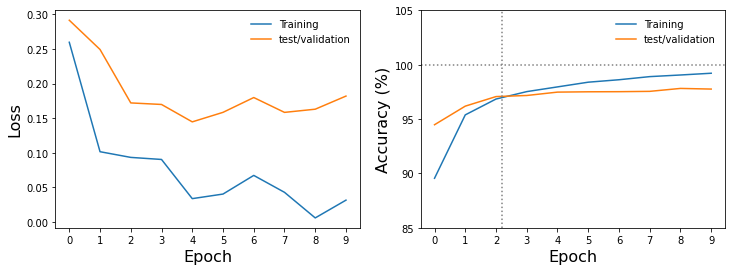

In [35]:
# Loss, Accuracy 시각화
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))   # 1행 2열, (12, 4) 사이즈의 그래프 그리기

ax[0].plot(Loss.train, label = 'Training')   # 학습 시의 Loss 그래프 (매 epoch)
ax[0].plot(Loss.test, label='test/validation')   # 평가 시의 Loss 그래프 (매 epoch)
ax[0].set_ylabel('Loss', fontsize=16)   # y축 label 설정

ax[1].plot(Accuracy.train, label = 'Training')   # 학습 시의 Accuracy 그래프 (매 epoch)
ax[1].plot(Accuracy.test, label='test/validation')   # 평가 시의 Accuracy 그래프 (매 epoch)
ax[1].set_yticks(range(85,110,5))   # y축의 눈금 label 설정
ax[1].axvline(x=2.2, color='gray', linestyle=':')   # x=2 vertical line, 회색 점선 그리기
ax[1].axhline(y=100, color='gray', linestyle=':')   # y=100 horizontal line, 회색 점선 그리기
ax[1].set_ylabel('Accuracy (%)', fontsize=16)   # y축 label 설정

for myax in ax:
    myax.set_xlabel('Epoch', fontsize=16)   # x축 label 설정
    myax.set_xticks(range(epochs))   # x축 눈금을 epoch_idx로 설정
    myax.legend(frameon=False)   # legend의 frame 제거

In [36]:
# 최종적인 test 성능 평가하기
test_loader = DataLoader(test_data, batch_size=10000, shuffle=False)   # 모든 test data를 한 번에 다 써서 평가할 수 있도록 DataLoader 구성

with torch.no_grad():   # gradient calculation 및 update를 진행하지 않을 것이므로 torch.no_grad() 선언
    correct = 0   # 총 맞은 개수
    
    for X, y_label in test_loader:
        y_val = mnist_classifier(X.view(X.shape[0], -1))   # 현 batch shape은 (10000, 1, 28, 28) -> 1차원 벡터로 변환해주어야 하므로 (10000, 784)로 reshape. y_val의 shape은 (10000,)
        _, predicted= torch.max(y_val, dim=1)   # 10개 logit 중에서 가장 큰 값의 label을 추출하여 predicted 변수에 저장
        correct += (predicted == y_label).sum()   # 예측 label과 정답 label을 비교하여 총 True의 개수를 구해 correct 변수에 누적합
        
print(f"Test Accuracy: {correct.item()*100/len(test_data):2.4f}%")   # correct 변수는 Tensor 타입이므로 int로 변환하고 총 테스트 데이터 개수로 나누어 최종 accuracy 구하기

Test Accuracy: 97.7600%


In [37]:
### confusion_matrix()
    # y_true (벡터)와 y_pred (벡터)를 input으로 받는다.
    # confusion matrix의 ij번째 element는 true_label이 i이고 predicted_label이 j인 데이터 개수를 나타낸다.
    # 즉, M[0,0]: 정답 label 0, 예측 label 0 | M[2,0]: 정답 label 2, 예측 label 0

from sklearn.metrics import confusion_matrix  # for evaluating results
confusion_array = confusion_matrix(y_true = y_label, y_pred = predicted)
confusion_array

array([[ 971,    1,    0,    0,    0,    0,    3,    1,    3,    1],
       [   0, 1124,    3,    2,    0,    0,    2,    1,    3,    0],
       [   6,    1, 1005,    3,    1,    0,    1,    9,    6,    0],
       [   0,    1,    3,  989,    1,    3,    0,    6,    3,    4],
       [   0,    0,    8,    0,  962,    0,    3,    4,    0,    5],
       [   3,    0,    0,    9,    2,  866,    4,    2,    5,    1],
       [   5,    1,    1,    1,    6,    2,  938,    0,    4,    0],
       [   0,    2,   10,    0,    2,    0,    0, 1010,    1,    3],
       [   6,    0,    5,    4,    3,    3,    1,    5,  943,    4],
       [   3,    2,    0,    6,   15,    3,    0,   10,    2,  968]],
      dtype=int64)